# `fsLR-5k` connectomes v0.2.3

In [5]:
import os
import nibabel as nib
import numpy as np
from brainspace.plotting import plot_hemispheres
from brainspace.mesh.mesh_io import read_surface


In [2]:
def load_data(File, data_type):
    """
    Loads and processes a connectome data.

    Parameters:
        File (str): Path to the file.
        data_type (str): Type of the data. It can be 'GD', 'SC', 'FC', or 'MPC'.

    Returns:
        numpy.ndarray: Processed connectome data.
    """
    
    if data_type not in ['GD', 'SC', 'FC', 'MPC']:
        raise ValueError("Invalid data type. Please specify 'GD', 'SC', 'FC', or 'MPC'.")

    # Load the matrix
    data = nib.load(File).darrays[0].data
    
    if data_type != 'GD':
        # Mirror the matrix
        data = np.triu(data, 1) + data.T

    if data_type == 'FC':
        # Fisher transform
        data = np.arctanh(data)

    # Replace infinite values with epsilon
    data[~np.isfinite(data)] = np.finfo(float).eps
    
    # Replace 0 with epsilon
    data[data == 0] = np.finfo(float).eps
    
    return data

In [6]:
# Path to MICAPIPE from global enviroment
micapipe=os.popen("echo $MICAPIPE").read()[:-1] 

# Load fsLR-5k inflated surface
f5k_lh = read_surface(f'{micapipe}/surfaces/fsLR-5k.L.inflated.surf.gii', itype='gii')
f5k_rh = read_surface(f'{micapipe}/surfaces/fsLR-5k.R.inflated.surf.gii', itype='gii')

# fsLR-5k mask
mask_lh = nib.load(f'{micapipe}/surfaces/fsLR-5k.L.mask.shape.gii').darrays[0].data
mask_rh = nib.load(f'{micapipe}/surfaces/fsLR-5k.R.mask.shape.gii').darrays[0].data
mask_5k = np.concatenate((mask_lh, mask_rh), axis=0)


In [9]:
# Global variables
# Set the working directory to the 'out' directory
out='/data_/mica3/BIDS_PNI/derivatives'
os.chdir(out)

# This variable will be different for each subject
sub='PNC019'
ses='a1'
subjectID=f'sub-{sub}_ses-{ses}'           
subjectDir=f'micapipe_v0.2.0/sub-{sub}/ses-{ses}' 

acq_func='desc-me_task-rest_bold'
acq_mpc='acq-T1map'
surf='fsLR-5k'
mod = ['GD', 'SC', 'FC', 'MPC']

# Path to fsLR-5k matrices: GD, SC, FC and MPC
f5k_files = [f'{subjectDir}/dist/{subjectID}_surf-{surf}_GD.shape.gii',
             f'{subjectDir}/dwi/connectomes/{subjectID}_surf-{surf}_desc-iFOD2-40M-SIFT2_full-connectome.shape.gii',
             f'{subjectDir}/func/{acq_func}/surf/{subjectID}_surf-{surf}_desc-FC.shape.gii',
             f'{subjectDir}/mpc/{acq_mpc}/{subjectID}_surf-{surf}_desc-MPC.shape.gii']

# Load all the fsLR-5k matrices into a single array: {vertices x vertices x modality}
f5k_n = f5k_lh.points.shape[0]*2
f5k_array = np.empty((f5k_n, f5k_n, 4))

for i, f in enumerate(f5k_files):

    # Load the fsLR-32k connectome
    f5k_array[:,:,i] = load_data(f, mod[i])

/host/yeatman/local_raid/temporaryLocalProcessing/ipykernel_1528056/467389585.py:25: RuntimeWarning: divide by zero encountered in arctanh
  data = np.arctanh(data)


In [12]:
# Empty list of surface plots
surf_5k = [None] * len(mod)

# NaN color
nan_col = (0.8, 0.8, 0.8, 1)

for i, c in enumerate(mod):
    
    # Get the array
    mtx = f5k_array[:,:,i]
    
    # column mean
    c_mean = np.sum(mtx, axis=1)
    
    # mask the midwall
    c_mean[mask_5k==0] = np.nan
    
    # Add the new column mean array filled with NaN values in the midwall
    surf_5k[i] = c_mean
    

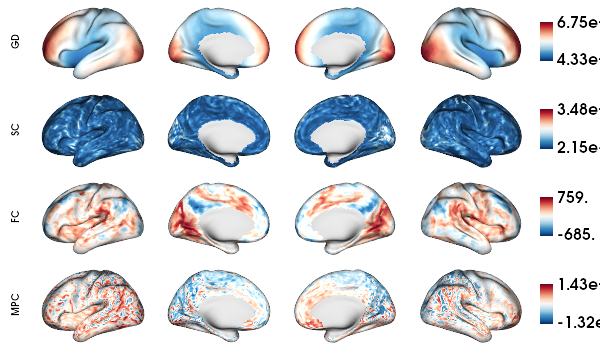

In [13]:
# Plot parcellations
plot_hemispheres(f5k_lh, f5k_rh, array_name=surf_5k, size=(600, 350), cmap='RdBu_r',
                 embed_nb=True, label_text={'left':mod}, color_bar='right',
                 zoom=1.5, nan_color = nan_col )